## Multiclass Text classification using BERT

Peforming a simple text classification task using the pretrained BERT model from Hugging Face

#### Loading the data

Using the *emotion* dataset from Hugging Face

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [1]:
from datasets import load_dataset
emotion = load_dataset('emotion')

Using custom data configuration default
Reusing dataset emotion (/home/studio-lab-user/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
label_names = emotion['train'].features['label'].names
label_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [4]:
# Let's take a look at what the text is like
emotion.set_format(type='pandas')
train_df = emotion['train'][:]
valid_df = emotion['validation'][:]
test_df = emotion['test'][:]

train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
# Using just 350 samples from each class for training and 70 samples for validation and 50 for testing

train_df = train_df.groupby(['label']).apply(lambda x: x.sample(350)).reset_index(drop=True)
valid_df = valid_df.groupby(['label']).apply(lambda x: x.sample(70)).reset_index(drop=True)
test_df = test_df.groupby(['label']).apply(lambda x: x.sample(50)).reset_index(drop=True)

train_df['label'].value_counts()

0    350
1    350
2    350
3    350
4    350
5    350
Name: label, dtype: int64

In [6]:
valid_df['label'].value_counts()

0    70
1    70
2    70
3    70
4    70
5    70
Name: label, dtype: int64

In [7]:
test_df['label'].value_counts()

0    50
1    50
2    50
3    50
4    50
5    50
Name: label, dtype: int64

### Tokenization

Tokenization is a process for splitting raw texts into tokens and encoding tokens into numeric data

In [8]:
# Using BertTokenizer
from transformers import BertTokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [9]:
# define a function for encoding
def encode(docs):
    """
    This function takes list of texts and returns input_ids and attention mask of texts
    """
    encoded_dict = tokenizer.batch_encode_plus(docs, 
                                              add_special_tokens=True,
                                              max_length=128,
                                              padding="max_length")
    
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [34]:
# testing the encode function to get input ids and attention masks of the datasets
train_input_ids, train_attn_masks = torch.LongTensor(encode(train_df['text'].values.tolist()))
valid_input_ids, valid_attn_masks = torch.LongTensor(encode(valid_df['text'].values.tolist()))
test_input_ids, test_attn_masks = torch.LongTensor(encode(test_df['text'].values.tolist()))

### Creating Datasets and DataLoaders 

Using **Pytorch** *Dataloader* and *Dataset* to split the data into batches

Turn the labels into tensors

In [35]:
y_train = torch.LongTensor(train_df['label'].values.tolist())
y_valid = torch.LongTensor(valid_df['label'].values.tolist())
y_test = torch.LongTensor(test_df['label'].values.tolist())

y_train.size(), y_valid.size(), y_test.size()

(torch.Size([2100]), torch.Size([420]), torch.Size([300]))

In [60]:
BATCH_SIZE = 16

train_dataset = TensorDataset(train_input_ids, train_attn_masks, y_train)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_attn_masks, y_valid)
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_attn_masks, y_test)
test_sampler = RandomSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [37]:
for batch in train_dataloader:
    break

## BERT FOR SEQUENCE CLASSIFICATION MODEL

Initiating the *BertForSequenceClassification*, which allows easily fine-tuning the pretrained BERT mode for classification task

In [38]:
from transformers import BertForSequenceClassification
N_labels = len(train_df.label.unique())
bert_model = BertForSequenceClassification.from_pretrained(model_name,
                                                          num_labels=N_labels,
                                                          output_attentions=False,
                                                          output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

if device == 'cuda':
    model = model.cuda()

cpu is available


### Fine-Tuning

#### Optimizer and scheduler

An *optimizer* is for tuning parameters in the model, which is set up with a learning rate

Selection of the learning rate is important, it's common to use a **Scheduler** to decrease the learning rate during training

In [40]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 2
LEARNING_RATE = 2e-6

optimizer = AdamW(bert_model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader)*EPOCHS
)

### TRAINING LOOP

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task

In [49]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch_num in range(EPOCHS):
    print(f'Epoch {epoch_num + 1}')
    """
    Training
    """
    bert_model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader, desc='Training')):
        input_ids, attn_mask, labels = [data.to(device) for data in batch_data]
        output = bert_model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
        
        loss = output.loss
        train_loss += loss.item()
        
        bert_model.zero_grad()
        loss.backward()
        del loss
        
        clip_grad_norm_(parameters=bert_model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
    train_loss_per_epoch.append(train_loss / (step_num + 1))
    
    """
    Validation
    """
    bert_model.eval()
    valid_loss = 0
    valid_pred = []
    
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader, desc='Validation')):
            input_ids, attn_mask, labels = [data.to(device) for data in batch_data]
            output = bert_model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
            
            loss = output.loss
            valid_loss += loss.item()
            
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(), axis=-1))
            
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)
    
    """
    Loss message
    """
    print(f"{step_num+1}/{math.ceil(len(train_df)/BATCH_SIZE)} train loss: {train_loss / (step_num + 1)}")
    print(f"{step_num_e+1}/{math.ceil(len(valid_df)/BATCH_SIZE)} val loss: {valid_loss / (step_num_e + 1)}")

Epoch 1


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.754217567768964
27/27 val loss: 1.7429619718480993
Epoch 2


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.7507718232544986
27/27 val loss: 1.7505277836764301


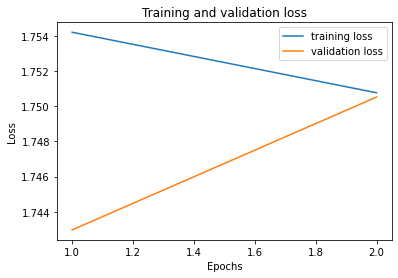

In [51]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS+1)
fig, ax = plt.subplots()
ax.plot(epochs, train_loss_per_epoch, label='training loss')
ax.plot(epochs, val_loss_per_epoch, label='validation loss')
ax.set_title('Training and validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

### Performance metrics

It's common to use precision, recall and F1-Score as the performance metrics

In [52]:
from sklearn.metrics import classification_report
print('Classification report')

print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

Classification report
              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00         8
         joy       0.07      0.14      0.09        36
        love       0.39      0.20      0.26       135
       anger       0.14      0.18      0.16        57
        fear       0.24      0.13      0.17       129
    surprise       0.14      0.18      0.16        55

    accuracy                           0.16       420
   macro avg       0.16      0.14      0.14       420
weighted avg       0.24      0.16      0.19       420



## Error Analysis

With the predictions, we can plot the confusion matrix

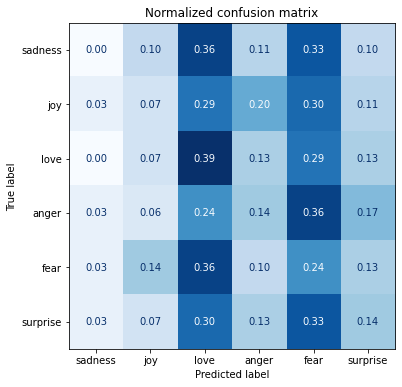

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_preds, y_true, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()
    

plot_confusion_matrix(valid_pred, valid_df['label'].to_numpy(), labels=label_names)

*Sadness* has a higher likelihood to classified as *anger* or *fear*, leading to a lower f1 score

## Prediction
Now, it's time to use the trained model to predict the testing set

In [64]:
bert_model.eval()
test_pred = []
test_loss = 0
with torch.no_grad():
    for step_num, batch_data in enumerate(tqdm(test_dataloader, desc='Testing')):
        input_ids, attn_mask, labels = [data.to(device) for data in batch_data]
        output = bert_model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
        
        loss = output.loss
        test_loss += loss.item()
        
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(), axis=-1))
        
test_pred = np.concatenate(test_pred)

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [61]:
for batch in test_dataloader:
    break

In [62]:
batch

[tensor([[ 101, 1045, 2514,  ...,    0,    0,    0],
         [ 101, 1045, 2064,  ...,    0,    0,    0],
         [ 101, 1045, 2113,  ...,    0,    0,    0],
         ...,
         [ 101, 1045, 2514,  ...,    0,    0,    0],
         [ 101, 1045, 3133,  ...,    0,    0,    0],
         [ 101, 1045, 4299,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([4, 4, 4, 0, 0, 1, 0, 5, 0, 3, 1, 5, 3, 3, 0, 1])]